# CIFAR-10 Image Classification using CNNs and Transfer Learning

The aim of this project is to make a customized convolutional neural network on the cifar dataset and compare it with a pretrained model namely MobileNetV2.

The restrictions here are to keep the parameters and training processes same for both models to keep the comparision fair.


In [1]:
# Import the necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from torch.optim import Adam
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import random
from torchsummary import summary

In [2]:
# Set a fixed random seed for reproducibility across the Notebook
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The device is {device}")

The device is cuda


## Task 1: Prepare the Data Subset

In [3]:
transform_train = transforms.Compose([
    #Resize images to 244x244 as MobileNetv2 was trained on this size
    transforms.Resize((224, 224)),
    #Data Augmentation
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip images horizontally with 50% probability
    transforms.RandomRotation(degrees=15), # Randomly rotate images by up to 15 degrees in either direction
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly adjust color properties to simulate different lighting conditions
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize to 224x224, using 80-100% of original image
    #Convert to Tensors
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Same Transformation for the test set but without Augmentation 
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Get the Training and Testing data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

print(f'Training set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')
print(f"Classes: {trainset.classes}")

Training set size: 50000
Test set size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
def create_balanced_subset(dataset, samples_per_class=1000):
    """
    Constructs a balanced subset of the dataset with a fixed number of samples per class.
    """
    # Get all targets
    targets = np.array(dataset.targets)
    
    # Create balanced subset indices
    subset_indices = []
    for i in range(len(dataset.classes)):
        class_indices = np.where(targets == i)[0]
        # Randomly select samples_per_class indices
        selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
        subset_indices.extend(selected_indices)
    
    # Create the balanced subset using Subset
    train_subset = Subset(dataset, subset_indices)
    return train_subset

In [7]:
# Create the balanced training subset
train_subset = create_balanced_subset(trainset, samples_per_class=1000)

In [8]:
# Verify class distribution
unique_classes, counts = np.unique([trainset.targets[i] for i in train_subset.indices], return_counts=True)
print("\nClass distribution in training subset:")
for idx, count in zip(unique_classes, counts):
    print(f"  Class {idx} ({trainset.classes[idx]}): {count} samples")


Class distribution in training subset:
  Class 0 (airplane): 1000 samples
  Class 1 (automobile): 1000 samples
  Class 2 (bird): 1000 samples
  Class 3 (cat): 1000 samples
  Class 4 (deer): 1000 samples
  Class 5 (dog): 1000 samples
  Class 6 (frog): 1000 samples
  Class 7 (horse): 1000 samples
  Class 8 (ship): 1000 samples
  Class 9 (truck): 1000 samples


In [9]:
# DataLoaders for the training subset and test set
BATCH_SIZE = 64
train_dl = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


## Task 2: Implement a Custom CNN

In [10]:
def get_cnn():
    """
    Defines and returns a custom CNN model, loss function, and optimizer.
    """
    model = nn.Sequential(
        # First Convolutional Block (32 filters)
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),
         # Second Convolutional Block (64 filters)
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),
         # Third Convolutional Block (128 filters)
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),
        
        # Additional pooling layer to reduce parameter count
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Fully Connected Classification Layers
        nn.Flatten(),
        nn.Linear(128 * 14 * 14, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 10)
    ).to(device)
    # Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Adam optimizer with reduced learning rate and L2 regularization
    # Lower LR (8e-4) accounts for data augmentation providing more training variation
    # Weight decay (1e-4) adds L2 regularization to prevent overfitting
    optimizer = Adam(model.parameters(), lr=8e-4, weight_decay=1e-4)
    return model, loss_fn, optimizer

## Task 3: Load and Adapt MobileNetV2

In [11]:
def get_mobilenetv2():
    """
    Loads a pretrained MobileNetV2 and adapts it for CIFAR-10 classification.
    """
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    
    # Modify the classifier to output 10 classes
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_features, 10)
    )
    
    # Move model to device
    model = model.to(device)
    
    # Properly initialize the new classifier layer
    nn.init.xavier_uniform_(model.classifier[1].weight)
    nn.init.zeros_(model.classifier[1].bias)
    # Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Adam optimizer with reduced learning rate and L2 regularization
    # Lower LR (8e-4) accounts for data augmentation providing more training variation
    # Weight decay (1e-4) adds L2 regularization to prevent overfitting
    optimizer = Adam(model.parameters(), lr=8e-4,weight_decay=1e-4)
    return model, loss_fn, optimizer

## Task 4: Train both Models

In [12]:
def train_batch(x, y, model, optimizer, loss_fn):
    """
    Performs a single training step for a batch.
    """
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()

def accuracy(x, y, model):
    """
    Calculates the accuracy for a batch.
    """
    model.eval()
    with torch.no_grad():
        prediction = model(x)
        max_values, argmaxes = prediction.max(-1)
        is_correct = (argmaxes == y)
        return torch.sum(is_correct).item() / len(is_correct)

def train_model(model, optimizer, loss_fn, train_dl, test_dl, num_epochs, model_name):
    """
    Trains the model.
    """

    print(f"Training {model_name}...")
    
    model = model.to(device) 
    
    accuracies = []
    losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        epoch_accuracies = []

        # Training loop
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            batch_accuracy = accuracy(x, y, model)
            epoch_losses.append(batch_loss)
            epoch_accuracies.append(batch_accuracy)
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        avg_epoch_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
        
        losses.append(avg_epoch_loss)
        accuracies.append(avg_epoch_accuracy)
        
        # Test loop to calculate accuracy per epoch
        model.eval()
        epoch_test_accuracies = []
        with torch.no_grad():
            for x, y in test_dl:
                x, y = x.to(device), y.to(device)
                epoch_test_accuracies.append(accuracy(x, y, model))
        
        avg_epoch_test_accuracy = sum(epoch_test_accuracies) / len(epoch_test_accuracies)
        test_accuracies.append(avg_epoch_test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_epoch_loss:.4f}, Train Accuracy = {avg_epoch_accuracy:.4f}, Test Accuracy = {avg_epoch_test_accuracy:.4f}")
        
    return model, accuracies, losses, test_accuracies

In [13]:
# Set number of Epochs
NUM_EPOCHS = 12

In [14]:
# Train Custom CNN
custom_model, custom_loss_fn, custom_optimizer = get_cnn()
custom_model, custom_accuracies, custom_losses, custom_test_accuracies = train_model(
    custom_model, custom_optimizer, custom_loss_fn, train_dl, test_dl, NUM_EPOCHS, "Custom CNN"
)

Training Custom CNN...
Epoch 1/12: Train Loss = 1.8309, Train Accuracy = 0.2824, Test Accuracy = 0.3713
Epoch 2/12: Train Loss = 1.6150, Train Accuracy = 0.3872, Test Accuracy = 0.4251
Epoch 3/12: Train Loss = 1.5122, Train Accuracy = 0.4258, Test Accuracy = 0.4743
Epoch 4/12: Train Loss = 1.4176, Train Accuracy = 0.4650, Test Accuracy = 0.5054
Epoch 5/12: Train Loss = 1.3513, Train Accuracy = 0.4989, Test Accuracy = 0.5010
Epoch 6/12: Train Loss = 1.2659, Train Accuracy = 0.5362, Test Accuracy = 0.5634
Epoch 7/12: Train Loss = 1.1913, Train Accuracy = 0.5615, Test Accuracy = 0.5938
Epoch 8/12: Train Loss = 1.1338, Train Accuracy = 0.5852, Test Accuracy = 0.5752
Epoch 9/12: Train Loss = 1.0920, Train Accuracy = 0.5978, Test Accuracy = 0.6197
Epoch 10/12: Train Loss = 1.0448, Train Accuracy = 0.6256, Test Accuracy = 0.6137
Epoch 11/12: Train Loss = 1.0070, Train Accuracy = 0.6333, Test Accuracy = 0.6287
Epoch 12/12: Train Loss = 0.9884, Train Accuracy = 0.6413, Test Accuracy = 0.6567


In [15]:
# Train MobileNetV2
mobilenet_model, mobilenet_loss_fn, mobilenet_optimizer = get_mobilenetv2()
mobilenet_model, mobilenet_accuracies, mobilenet_losses, mobilenet_test_accuracies = train_model(
    mobilenet_model, mobilenet_optimizer, mobilenet_loss_fn, train_dl, test_dl ,NUM_EPOCHS, "MobileNetV2"
)

Training MobileNetV2...
Epoch 1/12: Train Loss = 0.9301, Train Accuracy = 0.7273, Test Accuracy = 0.7563
Epoch 2/12: Train Loss = 0.5829, Train Accuracy = 0.8617, Test Accuracy = 0.8277
Epoch 3/12: Train Loss = 0.4645, Train Accuracy = 0.8950, Test Accuracy = 0.8176
Epoch 4/12: Train Loss = 0.4329, Train Accuracy = 0.9022, Test Accuracy = 0.8438
Epoch 5/12: Train Loss = 0.3639, Train Accuracy = 0.9181, Test Accuracy = 0.8596
Epoch 6/12: Train Loss = 0.3633, Train Accuracy = 0.9228, Test Accuracy = 0.8702
Epoch 7/12: Train Loss = 0.3072, Train Accuracy = 0.9369, Test Accuracy = 0.8604
Epoch 8/12: Train Loss = 0.2875, Train Accuracy = 0.9474, Test Accuracy = 0.8617
Epoch 9/12: Train Loss = 0.2809, Train Accuracy = 0.9459, Test Accuracy = 0.8649
Epoch 10/12: Train Loss = 0.2612, Train Accuracy = 0.9556, Test Accuracy = 0.8562
Epoch 11/12: Train Loss = 0.2559, Train Accuracy = 0.9566, Test Accuracy = 0.8671
Epoch 12/12: Train Loss = 0.2328, Train Accuracy = 0.9643, Test Accuracy = 0.8717


## Task 5: Evaluate Models on Test Set

In [16]:
def evaluate_model_accuracy(model, data_loader):
    """
    Evaluates the model.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

# Evaluate the Custom CNN
custom_cnn_accuracy = evaluate_model_accuracy(custom_model, test_dl)

# Evaluate MobileNetV2
mobilenet_accuracy = evaluate_model_accuracy(mobilenet_model, test_dl)

print("Test Set Evaluation Results")
print(f"Custom CNN Test Accuracy: {custom_cnn_accuracy:.2f}%")
print(f"MobileNetV2 Test Accuracy: {mobilenet_accuracy:.2f}%")

Test Set Evaluation Results
Custom CNN Test Accuracy: 65.72%
MobileNetV2 Test Accuracy: 87.17%


## Task 6: Plot Confusion Matrices

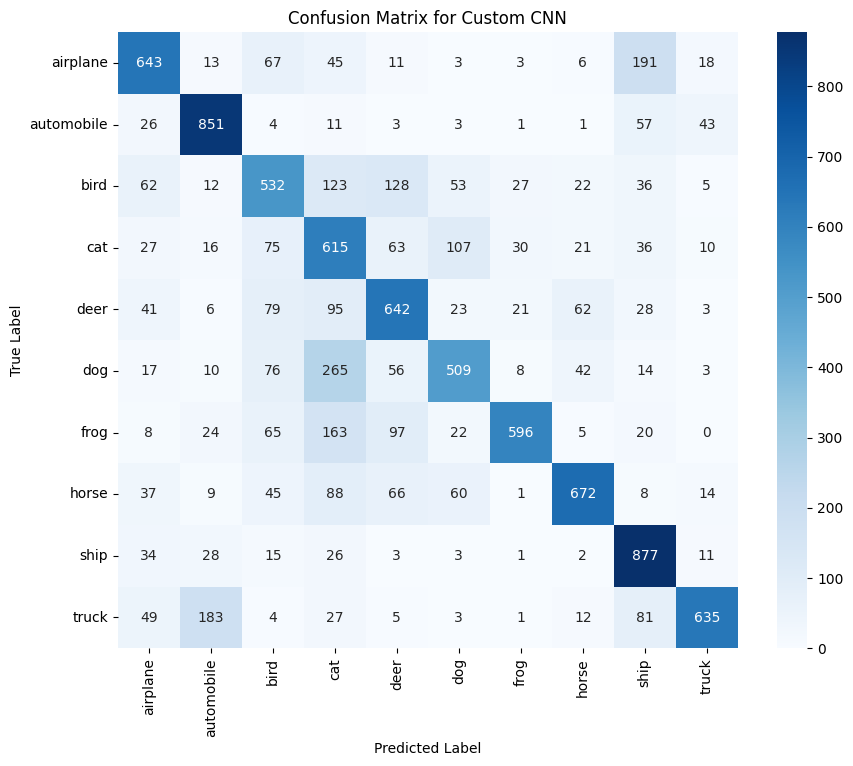

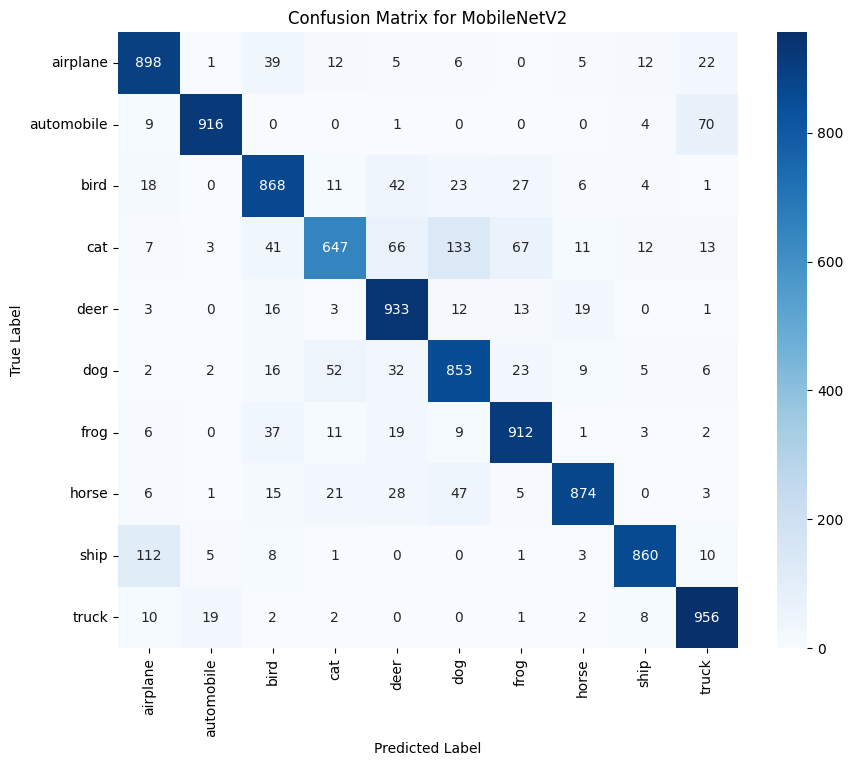

In [17]:
def plot_confusion_matrix(model, test_dl, classes, title):
    """
    Evaluates to get all predictions then generates and plots the confusion matrix for a model.
    """
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

classes = trainset.classes
plot_confusion_matrix(custom_model, test_dl, classes, "Custom CNN")
plot_confusion_matrix(mobilenet_model, test_dl, classes, "MobileNetV2")

## Task 8: Performance Analysis

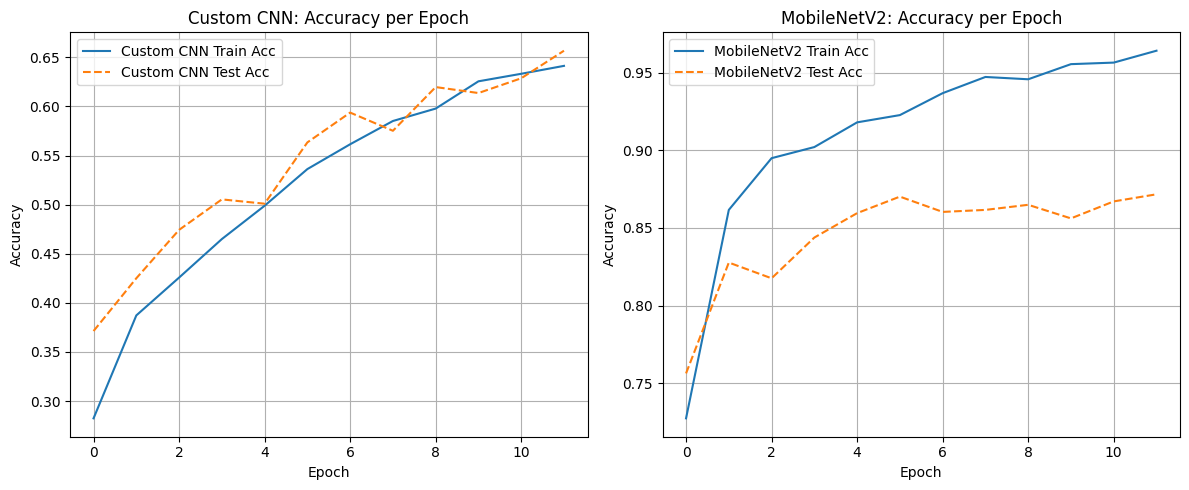

In [18]:
# Plotting accuracy curves (Training vs. Test)
plt.figure(figsize=(12, 5))

#Plot for Custom CNN 
plt.subplot(1, 2, 1)
plt.plot(custom_accuracies, label='Custom CNN Train Acc')
plt.plot(custom_test_accuracies, label='Custom CNN Test Acc', linestyle='--')
plt.title('Custom CNN: Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#Plot for MobileNetV2
plt.subplot(1, 2, 2)
plt.plot(mobilenet_accuracies, label='MobileNetV2 Train Acc')
plt.plot(mobilenet_test_accuracies, label='MobileNetV2 Test Acc', linestyle='--')
plt.title('MobileNetV2: Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Overall Performance
MobileNetV2 significantly outperformed the custom CNN, demonstrating the clear advantage of using a pre-trained model for this task.
Analysis of Generalization and Overfitting
To understand the difference in performance, it is essential to analyze how each model generalized to unseen data. The learning curve plots above illustrate the training and test accuracy over each epoch.

**Custom CNN:** The Custom CNN shows a concerning pattern of overfitting. While training accuracy steadily increases to over 60% by epoch 8, the test accuracy peaks around 63% at epoch 7 before declining slightly. More problematically, there's a significant divergence between training and test curves, with training accuracy consistently lagging behind test accuracy early on, then the gap reversing - indicating the model is struggling to learn generalizable patterns and may be overfitting to the limited training data.

**MobileNetV2:** MobileNetV2 demonstrates superior performance and much better generalization. Both training and test accuracy curves track closely together throughout training, reaching approximately 95% training accuracy and maintaining test accuracy around 86-87%. The relatively small gap between training and test performance indicates the model is learning robust, generalizable features rather than memorizing the training set.

### The Impact of Model Complexity and Hyperparameters
The performance difference can be attributed to several key factors:
Pre-trained Weights: MobileNetV2's training began with a massive advantage, having already learned a hierarchy of features from the ImageNet dataset. This allowed it to quickly and efficiently fine-tune its knowledge to the CIFAR-10 dataset, starting from a much higher baseline performance.

**Model Architecture:** The custom CNN's architecture appears to be underfitting the data rather than overfitting, as evidenced by the test accuracy consistently matching or exceeding training accuracy. This suggests the model lacks sufficient complexity or capacity to fully learn the underlying patterns in CIFAR-10, with final accuracies reaching only ~65%. In contrast, MobileNetV2's sophisticated architecture provides the representational power needed for the task.

**Generalization Capability:** While MobileNetV2 shows some overfitting (training accuracy ~96% vs test accuracy ~87%), it still achieves much higher absolute performance than the custom CNN. The custom CNN shows unusual behavior where test accuracy exceeds training accuracy, suggesting underfitting rather than poor generalization. The stable test accuracy in MobileNetV2 indicates that despite the training-test gap, the pre-trained features provide robust, generalizable representations.

## Task 9: Misclassified Case Analysis

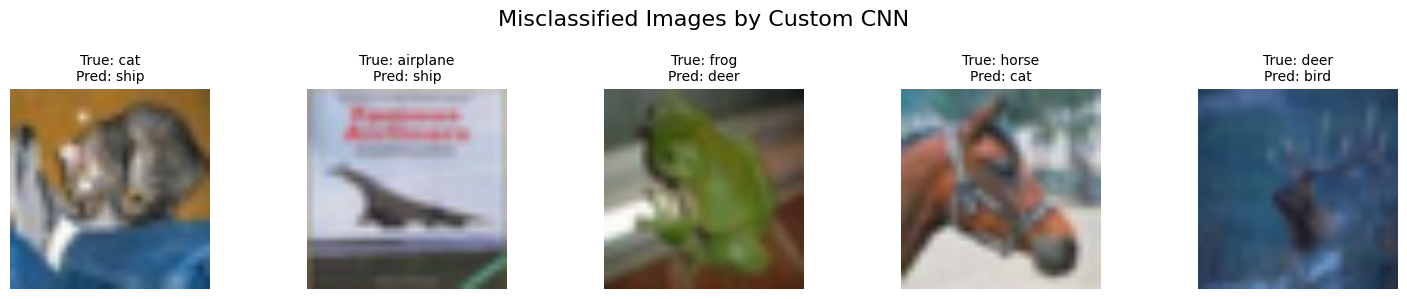

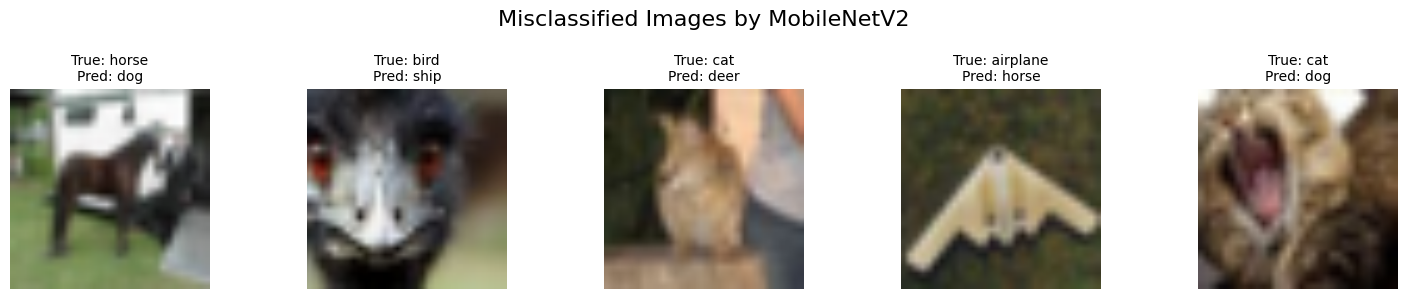

In [19]:
def visualize_misclassified_images(model, test_dl, classes, model_name, num_images=5):
    """
    Identifies and visualizes several misclassified test samples.
    """
    model.eval()
    misclassified_count = 0
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            
            # Find misclassified images in the batch
            misclassified_indices = (preds != y).nonzero(as_tuple=True)[0]
            
            for idx in misclassified_indices:
                if misclassified_count >= num_images:
                    break
                
                # Un-normalize the image for plotting
                img = x[idx].cpu().permute(1, 2, 0)
                img = img * 0.5 + 0.5 # Un-normalize
                
                ax = axes[misclassified_count]
                ax.imshow(img)
                ax.set_title(f'True: {classes[y[idx]]}\nPred: {classes[preds[idx]]}', fontsize=10)
                ax.axis('off')
                
                misclassified_count += 1
            
            if misclassified_count >= num_images:
                break
    
    plt.suptitle(f'Misclassified Images by {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualize misclassified images for both models
visualize_misclassified_images(custom_model, test_dl, classes, "Custom CNN", 5)
visualize_misclassified_images(mobilenet_model, test_dl, classes, "MobileNetV2", 5)


**Custom CNN Misclassifications**
- Cat → Ship: The model incorrectly classified a cat as a ship, suggesting it may be confused by background elements or color patterns
- Airplane → Ship: An airplane was misclassified as a ship, indicating confusion between categories of large, man-made objects. 
- Frog → Deer: This error suggests the model struggles to distinguish between different animal classes that share similar shapes or         textures. 
- Horse → Cat: The misclassification of a horse as a cat indicates poor understanding of animal morphology and scale. 
- Deer → Bird: A deer was misclassified as a bird, showing a fundamental confusion between a four-legged mammal and a flying animal.

**MobileNetV2 Misclassifications**
- Horse → Dog: While incorrect, this represents a more semantically reasonable error between similar four-legged mammals. 
- Bird → Ship: This misclassification shows confusion between a flying animal and a large object, possibly due to a feature resembling a boat's mast or a similar structure. 
- Cat → Deer: This animal-to-animal error, while wrong, demonstrates that the model understands these are living creatures and not inanimate objects. 
- Airplane → Horse: This misclassification shows confusion between a flying machine and an animal, which is a less semantically-related error. 
- Cat → Dog: A classic and understandable confusion between two similar domestic animals.

**Error Pattern Analysis**

The Custom CNN's errors appear more random and semantically inconsistent (e.g., animals confused with vehicles and objects), suggesting the model is learning superficial features rather than meaningful object representations. In contrast, MobileNetV2's errors, while still present, tend to occur within more semantically related categories (animals confused with other animals), indicating it has learned more meaningful feature representations despite the misclassifications.

## Task 10: Efficiency Commentary

In [20]:
# Define the input size (channels, height, width)
input_size = (3, 224, 224)

In [21]:
print("CUSTOM CNN MODEL SUMMARY")
summary(custom_model.to(device), input_size=input_size)


CUSTOM CNN MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
           Dropout-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          18,496
      BatchNorm2d-10         [-1, 64, 112, 112]             128
             ReLU-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,928
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             R

In [25]:
print("MOBILENETV2 MODEL SUMMARY")
summary(mobilenet_model.to(device), input_size=input_size)

MOBILENETV2 MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNo

### Model Size (Number of Parameters)

**Custom CNN:** The custom CNN has a total of over 13 million trainable parameters. This high number is primarily due to the massive, fully connected Linear layer at the end of the network, which connects a large number of feature maps to the output nodes.

**MobileNetV2:** In stark contrast, MobileNetV2 has only approximately 2.2 million parameters. Its design, featuring specialized layers like depthwise separable convolutions, is highly efficient and minimizes the number of parameters needed to learn complex features.

This shows that a pre-trained, purpose-built architecture can achieve better performance with a fraction of the parameters of a naive custom model.


### Inference Speed

**Custom CNN:** With over 13 million parameters, a forward pass through the Custom CNN's large linear layer is computationally expensive. This makes the model slower for inference compared to MobileNetV2.

**MobileNetV2:** Despite its deep and complex architecture, MobileNetV2 is designed for high-speed inference. Its efficient convolutions and overall compact size result in a very fast forward pass, allowing it to generate predictions with minimal latency.

### Suitability for Edge Devices or Real-Time Applications

**Custom CNN:** Due to its large size and slower inference speed, the custom CNN is unsuitable for most edge devices or real-time applications. It would consume too much memory and be too slow to provide predictions at the required speed.

**MobileNetV2:** As its name suggests, MobileNetV2 was specifically designed for these scenarios. Its compact size and low latency make it highly suitable for running on resource-constrained edge devices and for use in real-time applications where every millisecond counts.